# Complex systems simulation

Kevin: This is the closest algorithm I can formulate when analyzing the papers. Maybe it'll be useful. Please tell me or correct it if you think something is missing or wrong here. I find that it resembles the BTW algorithm somewhat, so we'll probably find some SOC by that resemblance alone. I added both the dynamics synapses and leak parts. I think they can be ignored quite easily if we don't want those elements though.

## (Leaky) integrate and fire algorithm with LHG dynamics

1. Initialize network with potentials $V_i$ for the node values and Synaptic strengths $J_{ij}$ for the link values with $J_{ij} \neq J_{ji}$

2. Initialize parameters:
    - $V^{ext}$: External input into membrane potential
    - $u$: Transmitter resource usage / saturation constant of synaptic strength
    - $V^{th}$: Membrane potential threshold
    - $\alpha$: Maximum connection strength parameter (Dynamic synapses)
    - $\tau_{J}$: Synaptic strength relaxation time (Dynamic synapses)
    - $\tau_l$: Leak time constant (leak term)
    - $C$: Compensatory synaptic current (leak term)

3. Drive step:
    - $V_j \gets V_j - \frac{V_j}{\tau_l} + C$ for all neurons $j$
    - Randomly select a neuron i
    - $V_i \gets V_i + V^{ext}$ (Forward Euler)

4. Relaxation step:
    - For all neighbors $j$ of $i$, if $V_i > V^{th}$:
        - $V_j \gets V_j + \frac{u J_{ji}}{N_i}$
    
    - $V_i \gets V_i - V^{th}$
    - Repeat for all cases of $j$ where $V_j > V^{th}$
    
5. Update synaptic strength:
    - $J_{ij} \gets J_{ij} + \frac{1}{\tau_l}\left( \frac{\alpha}{u} - J_{ij} \right) - u J_{ij}$ for all spiked synapses
    - $J_{ij} \gets J_{ij} + \frac{1}{\tau_l}\left( \frac{\alpha}{u} - J_{ij} \right)$ for all unused synapses

6. Go back to step 3 or terminate algorithm

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random
import scipy as sp
from scipy import sparse

import integrate_and_fire as int_fire
import powerlaw

# Repair

In [2]:
def remove_links(matrix, n):
    "Removes n links from adjacency matrix"
    r = list(zip(np.where(A != 0)[0], np.where(matrix != 0)[1]))
    k = random.sample(r, n)
    s = np.array(k)
    matrix[s[:,0], s[:,1]] = 0
    return matrix

In [3]:
size = 50
network = int_fire.create_if_network(size, net_type="full")
model = int_fire.LHG_integrate_and_fire_model(network,a=0.95, p_inh=0.2)
# print("Average weight", np.average(model.w.toarray()))

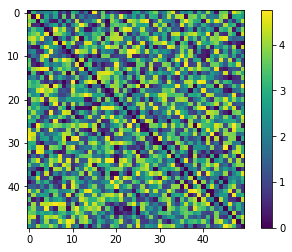

In [4]:
A = model.w.toarray()
plt.imshow(A)
plt.colorbar()
plt.show()

In [5]:
model.reset_avalanche_stats()

model.simulate(1000)
print("Average weight", np.average(model.w.toarray()))

100%|██████████| 1000/1000 [00:03<00:00, 286.62it/s]

Average weight 4.11301687727


Calculating best minimal value for power law fit
/home/abel/Documents/anaconda2/envs/ml1labs/lib/python3.6/site-packages/powerlaw.py:697: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


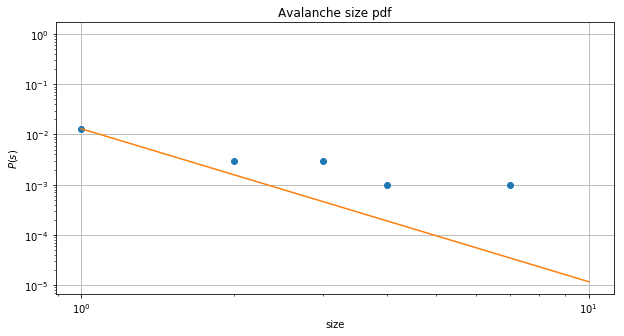

In [6]:
plt.figure(figsize=(10,5))
plt.title("Avalanche size pdf")
plt.ylabel(r"$P(s)$")
plt.xlabel(r"size")

indices,pdf = model.avalanche_size_pdf()
fitted_pl = powerlaw.Fit(pdf[1:])
alpha = fitted_pl.alpha
x = np.linspace(1, 10, 100)
y = x**(-alpha) * pdf[1]

plt.loglog(indices,pdf, 'o')
plt.loglog(x,y)
plt.grid(True)
plt.show()

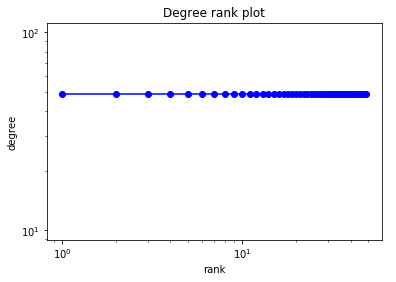

In [7]:
degree_sequence=sorted(nx.degree(nx.from_scipy_sparse_matrix(model.w)).values(),reverse=True) # degree sequence
dmax=max(degree_sequence)
plt.loglog(degree_sequence,'b-',marker='o')
plt.title("Degree rank plot")
plt.ylabel("degree")
plt.xlabel("rank")

# draw graph in inset
plt.axes([0.45,0.45,0.45,0.45])
Gcc=sorted(nx.connected_component_subgraphs(network), key = len, reverse=True)[0]
pos=nx.spring_layout(Gcc)
plt.axis('off')

plt.savefig("degree_histogram.png")
plt.show()

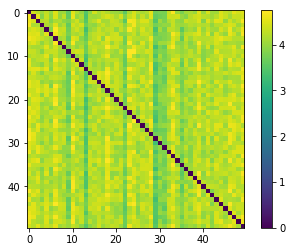

In [8]:
A = model.w.toarray()
plt.imshow(A)
plt.colorbar()
plt.show()

### REMOVE

In [10]:
A = model.w.toarray()

A = remove_links(A, 500)

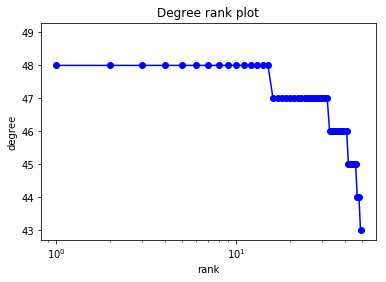

In [11]:
model.w = sparse.csc_matrix(A)
degree_sequence=sorted(nx.degree(nx.from_scipy_sparse_matrix(model.w)).values(),reverse=True) # degree sequence
dmax=max(degree_sequence)
plt.semilogx(degree_sequence,'b-',marker='o')
plt.title("Degree rank plot")
plt.ylabel("degree")
plt.xlabel("rank")

# plt.savefig("degree_histogram.png")
plt.show()

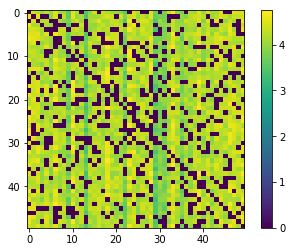

In [12]:
A = model.w.toarray()
plt.imshow(A)
plt.colorbar()
plt.show()

In [13]:
model = int_fire.LHG_integrate_and_fire_model(network,p_inh=0.,a=0.5,A=A)

model.reset_avalanche_stats()

model.simulate(1000)

100%|██████████| 1000/1000 [00:15<00:00, 62.58it/s]


In [14]:
model.w

<50x50 sparse matrix of type '<class 'numpy.float64'>'
	with 2338 stored elements in Compressed Sparse Row format>

Calculating best minimal value for power law fit
/home/abel/Documents/anaconda2/envs/ml1labs/lib/python3.6/site-packages/powerlaw.py:697: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


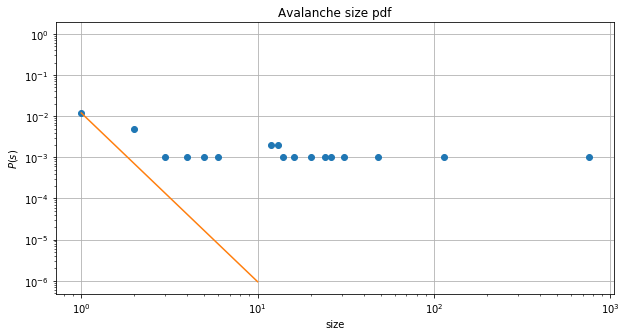

In [15]:
plt.figure(figsize=(10,5))
plt.title("Avalanche size pdf")
plt.ylabel(r"$P(s)$")
plt.xlabel(r"size")

indices,pdf = model.avalanche_size_pdf()
fitted_pl = powerlaw.Fit(pdf[1:])
alpha = fitted_pl.alpha
x = np.linspace(1, 10, 100)
y = x**(-alpha) * pdf[1]

plt.loglog(indices,pdf, 'o')
plt.loglog(x,y)
plt.grid(True)
plt.show()

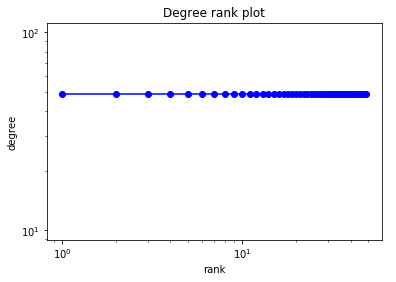

In [16]:
degree_sequence=sorted(nx.degree(network).values(),reverse=True) # degree sequence
dmax=max(degree_sequence)
plt.loglog(degree_sequence,'b-',marker='o')
plt.title("Degree rank plot")
plt.ylabel("degree")
plt.xlabel("rank")

# draw graph in inset
plt.axes([0.45,0.45,0.45,0.45])
Gcc=sorted(nx.connected_component_subgraphs(network), key = len, reverse=True)[0]
pos=nx.spring_layout(Gcc)
plt.axis('off')

plt.savefig("degree_histogram.png")
plt.show()

In [17]:
model = int_fire.LHG_integrate_and_fire_model(network,a=0.95,p_inh=0.)

model.reset_avalanche_stats()

model.simulate(10000)

100%|██████████| 10000/10000 [00:47<00:00, 208.83it/s]


Calculating best minimal value for power law fit
/home/abel/Documents/anaconda2/envs/ml1labs/lib/python3.6/site-packages/powerlaw.py:697: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


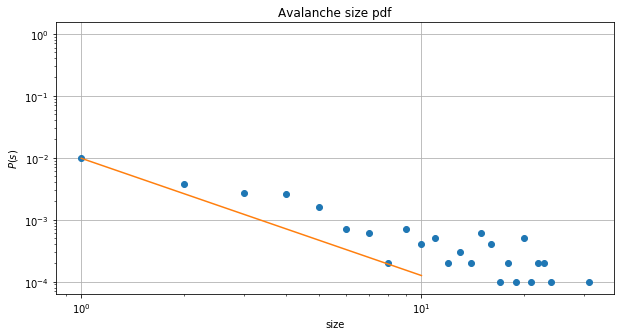

In [18]:
plt.figure(figsize=(10,5))
plt.title("Avalanche size pdf")
plt.ylabel(r"$P(s)$")
plt.xlabel(r"size")

indices,pdf = model.avalanche_size_pdf()
fitted_pl = powerlaw.Fit(pdf[1:])
alpha = fitted_pl.alpha
x = np.linspace(1, 10, 100)
y = x**(-alpha) * pdf[1]

plt.loglog(indices,pdf, 'o')
plt.loglog(x,y)
plt.grid(True)
plt.show()

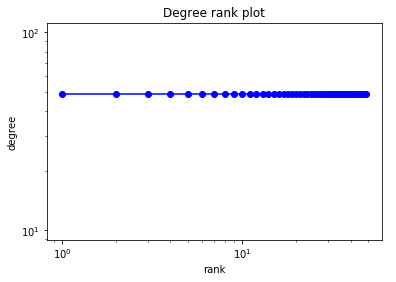

In [19]:
degree_sequence=sorted(nx.degree(network).values(),reverse=True) # degree sequence
dmax=max(degree_sequence)
plt.loglog(degree_sequence,'b-',marker='o')
plt.title("Degree rank plot")
plt.ylabel("degree")
plt.xlabel("rank")

# draw graph in inset
plt.axes([0.45,0.45,0.45,0.45])
Gcc=sorted(nx.connected_component_subgraphs(network), key = len, reverse=True)[0]
pos=nx.spring_layout(Gcc)
plt.axis('off')
# nx.draw_networkx_nodes(Gcc,pos,node_size=20)
# nx.draw_networkx_edges(Gcc,pos,alpha=0.4)

plt.savefig("degree_histogram.png")
plt.show()

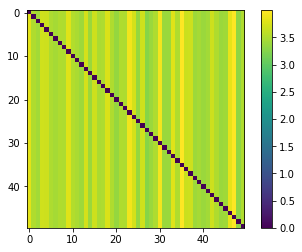

In [20]:
A = model.w.toarray()
plt.imshow(A)
plt.colorbar()
plt.show()

## Robustness

In [33]:
size = 50
network = int_fire.create_if_network(size, net_type="full")
model = int_fire.simple_integrate_and_fire_model(network, p_inh=0.2)
# print("Average weight", np.average(model.w.toarray()))

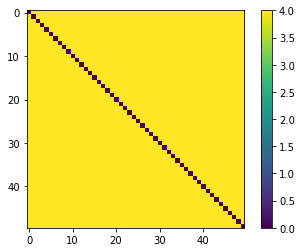

In [34]:
A = model.w.toarray()
plt.imshow(A)
plt.colorbar()
plt.show()

In [35]:
model.simulate(1000)

100%|██████████| 1000/1000 [00:00<00:00, 2646.98it/s]


In [39]:
A = model.w.toarray()

A = remove_links(A, 50)

In [40]:
network = nx.from_numpy_matrix(A)
model = int_fire.simple_integrate_and_fire_model(network, p_inh=0.2)

In [ ]:
model.simulate(1000)

  0%|          | 0/1000 [00:00<?, ?it/s]